# 展示贪吃蛇游戏训练成果

## 模型预定义

In [5]:
import os
import time
from pathlib import Path
from typing import Tuple,List

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms as T
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.multiprocessing as mp

In [6]:
# ———————————————— 模型组件 ————————————————
class ConvBlock(nn.Module):
    def __init__(self, c_in, c_out, k=3, s=1, p=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(c_in, c_out, k, s, p, bias=False),
            nn.BatchNorm2d(c_out),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)


class SnakeEncoder(nn.Module):
    def __init__(self, emb_dim=64):
        super().__init__()
        self.enc = nn.Sequential(
            ConvBlock(3, 32, k=4, s=2, p=1),
            ConvBlock(32, 64, k=4, s=2, p=1),
            ConvBlock(64, 64),
            ConvBlock(64, 64),
        )
        self.project = nn.Conv2d(64, emb_dim, 1)
    def forward(self, x):
        h = self.enc(x)
        return self.project(h)  # [B,emb_dim,16,16]

class SnakeDecoder(nn.Module):
    def __init__(self, emb_dim=64):
        super().__init__()
        self.project = nn.Conv2d(emb_dim, 64, 1)
        self.dec = nn.Sequential(
            ConvBlock(64,64),
            ConvBlock(64,32),
            nn.ConvTranspose2d(32,32,4,2,1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32,3,4,2,1),
            nn.Sigmoid(),
        )
    def forward(self, z_q):
        return self.dec(self.project(z_q))


class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings:int, embedding_dim:int, beta:float=0.25):
        super().__init__()
        self.K, self.D, self.beta = num_embeddings, embedding_dim, beta
        self.embedding = nn.Embedding(self.K, self.D)
        nn.init.uniform_(self.embedding.weight, -1/self.K, 1/self.K)
    def forward(self, z_e):
        B,D,H,W = z_e.shape
        flat = z_e.permute(0,2,3,1).reshape(-1, D)
        dist = (flat.pow(2).sum(1,True)
                -2*flat@self.embedding.weight.t()
                +self.embedding.weight.pow(2).sum(1))
        idx = dist.argmin(1)
        z_q = self.embedding(idx).view(B,H,W,D).permute(0,3,1,2)
        # straight-through quantization
        z_q = z_e + (z_q - z_e).detach()
        return z_q


class VQVAE(nn.Module):
    def __init__(self, num_embeddings=128, embedding_dim=64, beta=0.25):
        super().__init__()
        self.enc = SnakeEncoder(embedding_dim)
        self.vq  = VectorQuantizer(num_embeddings, embedding_dim, beta)
        self.dec = SnakeDecoder(embedding_dim)
    def encode(self, x):
        z_e = self.enc(x)
        B,D,H,W = z_e.shape
        flat = z_e.permute(0,2,3,1).reshape(-1, D)
        dist = (flat.pow(2).sum(1,True)
                -2*flat@self.vq.embedding.weight.t()
                +self.vq.embedding.weight.pow(2).sum(1))
        idx = dist.argmin(1)
        return idx.view(B, H, W)
    def decode(self, idx):
        B,H,W = idx.shape
        flat = idx.view(-1)
        emb = self.vq.embedding.weight
        z_q = emb[flat].view(B,H,W,-1).permute(0,3,1,2)
        return self.dec(z_q)


# —————————————— LDM 定义 ——————————————
class CausalEncoder3D(nn.Module):
    def __init__(self, feat_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv3d(3,32,(3,4,4),(1,2,2),(1,1,1)),
            nn.BatchNorm3d(32), nn.ReLU(True),
            nn.Conv3d(32,64,(3,4,4),(1,2,2),(1,1,1)),
            nn.BatchNorm3d(64), nn.ReLU(True),
        )
        self.proj = nn.Conv3d(64, feat_dim, 1)
    def forward(self, x):  # x: [B,3,H+1,64,64]
        return self.proj(self.net(x))  # [B,feat,H+1,16,16]

class LatentDynamicsModel(nn.Module):
    def __init__(self, feat_dim=64, H=4, num_embeddings=128, beta=0.25):
        super().__init__()
        self.H = H
        self.encoder3d = CausalEncoder3D(feat_dim)
        self.queries   = nn.Parameter(torch.randn(H, feat_dim,1,1))
        self.embed     = nn.Conv2d(feat_dim, feat_dim, 1)
        self.codebook  = nn.Embedding(num_embeddings, feat_dim)
        nn.init.uniform_(self.codebook.weight, -1/num_embeddings, 1/num_embeddings)
    def forward(self, x_seq):  # x_seq: [B,3,H+1,64,64]
        B = x_seq.size(0)
        feats = self.encoder3d(x_seq)        # [B,feat,H+1,16,16]
        f_t   = feats[:,:, -1]               # [B,feat,16,16]
        z_qs = []
        for h in range(self.H):
            q = self.queries[h]
            z_e = self.embed(f_t * q)
            flat = z_e.permute(0,2,3,1).reshape(-1, z_e.size(1))
            dist = (flat.pow(2).sum(1,True)
                   -2*flat@self.codebook.weight.t()
                   +self.codebook.weight.pow(2).sum(1))
            idx = dist.argmin(1)
            z_q = self.codebook(idx).view(B,16,16,-1).permute(0,3,1,2)
            z_q = z_e + (z_q - z_e).detach()
            z_qs.append(z_q)
        return torch.stack(z_qs, dim=1)  # [B,H,feat,16,16]


# —————————————— Transformer 预测器 ——————————————
class TokenPredictorWithLDM(nn.Module):
    def __init__(self, num_embeddings=256, emb_dim=64, n_head=8, num_layers=4, H=4, feat_dim=64):
        super().__init__()
        self.base_len = 16*16
        self.H = H
        self.token_emb = nn.Embedding(num_embeddings, emb_dim)
        self.ldm_proj  = nn.Linear(feat_dim*16*16, emb_dim)
        total_len = self.base_len + H
        self.pos_emb   = nn.Parameter(torch.randn(1, total_len, emb_dim))
        layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=n_head,
                                           batch_first=True,
                                           dim_feedforward=emb_dim*4)
        self.transformer = nn.TransformerEncoder(layer, num_layers)
        self.head = nn.Linear(emb_dim, num_embeddings)

    def forward(self, idx, z_flat):
        # idx: [B,256], z_flat: [B,H,feat*16*16]
        tok_emb = self.token_emb(idx)            # [B,256,emb]
        z_emb   = self.ldm_proj(z_flat)          # [B,H,emb]
        x       = torch.cat([tok_emb, z_emb],1)  # [B,256+H,emb]
        x      += self.pos_emb[:,:,:x.size(1)]
        x       = self.transformer(x)            # [B,256+H,emb]
        return self.head(x)                      # [B,256+H,256]
    
# —————————————— 推断函数 ——————————————
def predict_next_frame(
    seq_paths: List[Path],
    vqvae: VQVAE,
    ldm: LatentDynamicsModel,
    predictor: TokenPredictorWithLDM,
    device: torch.device
) -> Image.Image:
    """
    给定 H+1 帧的文件路径列表 seq_paths（过去 H 帧 + 当前帧），
    返回预测的下一帧 PIL.Image
    """
    H = len(seq_paths) - 1
    transform = T.Compose([T.Resize((64,64)), T.ToTensor()])
    to_pil    = T.ToPILImage()

    # 1) 读取并预处理序列：构造 [1,3,H+1,64,64]
    imgs = [transform(Image.open(p).convert('RGB')).unsqueeze(1) for p in seq_paths]
    x_seq = torch.cat(imgs, dim=1).unsqueeze(0).to(device)

    # 2) 对当前帧编码为 token
    x_t = transform(Image.open(seq_paths[-1]).convert('RGB')).unsqueeze(0).to(device)
    idx_t = vqvae.encode(x_t).view(1, -1)  # [1,256]

    # 3) LDM 提取多步潜在码
    with torch.no_grad():
        z_q = ldm(x_seq)                      # [1,H,feat,16,16]
        B,_,C,h,w = z_q.shape
        z_flat = z_q.view(B, H, -1)           # [1,H,feat*16*16]

        # 4) Transformer 预测
        logits = predictor(idx_t, z_flat)     # [1,256+H,256]
        log_t  = logits[:, :idx_t.size(1), :] # [1,256,256]
        next_idx = log_t.argmax(-1).view(1,16,16)

        # 5) 解码成图像
        x_pred = vqvae.decode(next_idx).cpu().clamp(0,1).squeeze(0)

    return to_pil(x_pred)

## 预测下一帧的函数
输入一个图片，预测下一个图片

In [ ]:
H  = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
W_VQVAE = "weights/vqvae_20250607_155540.pth"
W_LDM  = "weights/ldm_checkpoint.pth"
W_PREDICTOR = "weights/predictor_ldm_20250617_071644.pth"

# 1) 构建模型并加载权重
vqvae     = VQVAE().to(device)
ldm       = LatentDynamicsModel(H=H).to(device)
predictor = TokenPredictorWithLDM(H=H).to(device)

vqvae.load_state_dict(torch.load(W_VQVAE, map_location=device))
ldm.load_state_dict(torch.load(W_LDM,   map_location=device))
predictor.load_state_dict(torch.load(W_PREDICTOR, map_location=device))

/tmp/ipykernel_2364469/962991724.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vqvae.load_state_dict(torch.load(W_VQVAE, map_location=device))
/tmp/ipykernel_2364469/

<All keys matched successfully>

In [16]:
# —————————————— 读取所有帧 ——————————————
idy = 3
root_dir = Path(f"test_{idy}")
out_dir    = Path("fig_pred_ldm")
out_dir.mkdir(exist_ok=True)
all_frames = sorted(root_dir.glob("*.png"))
N = len(all_frames)

# 如果帧数太多，可以只取前 M 个或后 M 个，这里默认全取：
# all_frames = all_frames[:M]  # 或 all_frames[-M:]

# —————————————— 逐窗推断并拼接每行 ——————————————
rows = []
frames_for_gif = []
for i in range(0, N-(H+1)):
    # 1) 构造序列：过去 H 帧 + 当前帧
    seq_paths = all_frames[i : i+H+1]        # 长度 H+1
    # 2) 预测下一帧
    pred_img = predict_next_frame(seq_paths, vqvae, ldm, predictor, device)
    frames_for_gif.append(pred_img)
    # 3) 读取真实“下一帧”
    true_img = Image.open(all_frames[i+H+1]).convert("RGB")
    # 4) 缩放到 64×64（如有必要）
    transform = T.Resize((64,64))
    true_img = transform(true_img)
    pred_img = transform(pred_img)
    # 5) 横向拼接成一行：左真右预测
    row = Image.new("RGB", (64*2, 64))
    row.paste(true_img, (0, 0))
    row.paste(pred_img, (64, 0))
    rows.append(row)

# —————————————— 纵向拼接所有行 ——————————————
if not rows:
    raise RuntimeError("帧数不足，无法做任何一次预测。")

w, h = rows[0].size  # 应该是 (128, 64)
big_img = Image.new("RGB", (w, h * len(rows)))
for idx, row in enumerate(rows):
    big_img.paste(row, (0, idx * h))

# —————————————— 保存最终长图 ——————————————
out_path = out_dir / f"compare_all_{idy}.png"
gif_path = out_dir / f"compare_animation_{idy}.gif"
big_img.save(out_path)

frames_for_gif[0].save(
    gif_path,
    save_all=True,
    append_images=frames_for_gif[1:],
    duration=300,
    loop=0
)


print(f"✅ 已保存对比长图：{out_path}")
print(f"✅ 已生成对比动画 GIF: {gif_path}")

✅ 已保存对比长图：fig_pred_ldm/compare_all_3.png
✅ 已生成对比动画 GIF: fig_pred_ldm/compare_animation_3.gif


## 自预测

/tmp/ipykernel_3180945/334623790.py:33: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3180945/334623790.py:33: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3180945/334623790.py:33: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3180945/334623790.py:33: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3180945/334623790.py:33: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3180945/334623790.py:33: UserWarning: Glyph 19979 (\N{CJK UNIFIED IDEOGRAPH-4E0B}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3180945/334623790.py:33: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from current font.

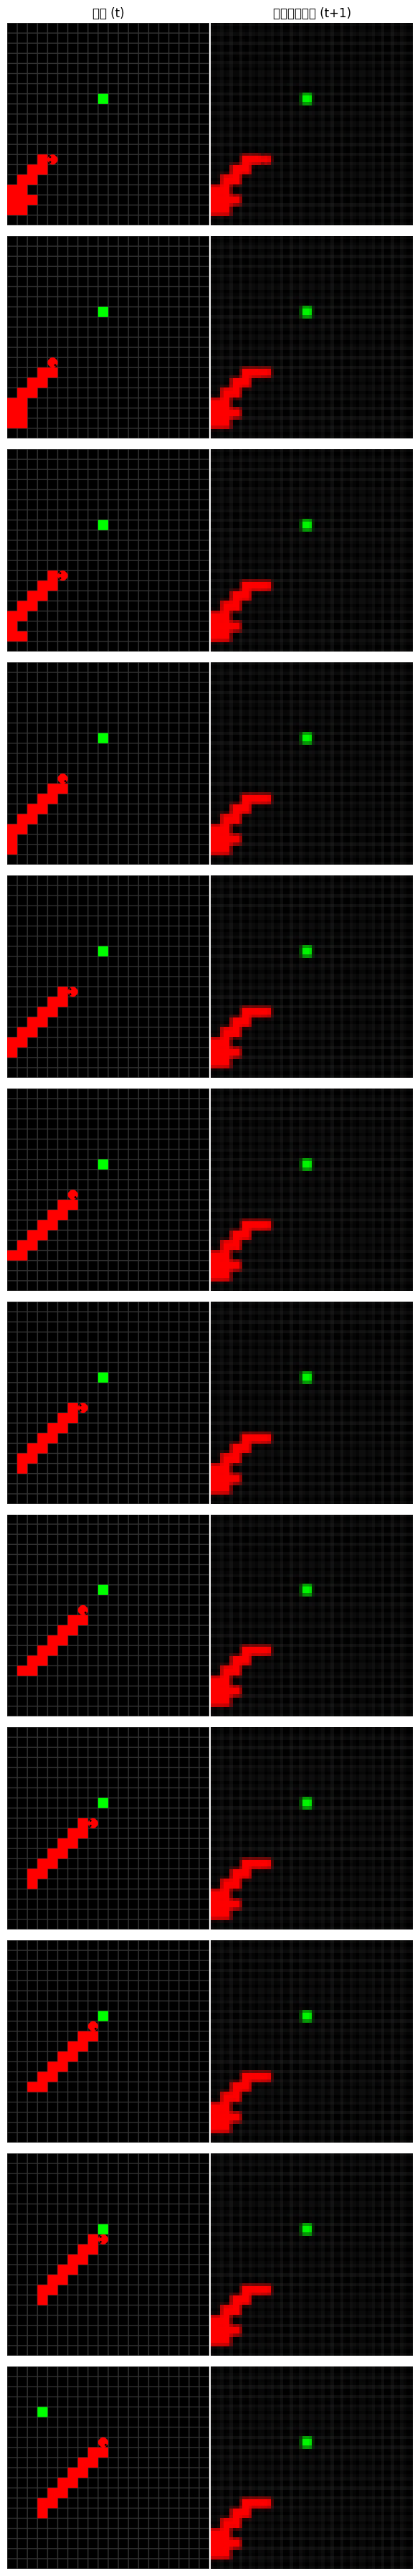

In [13]:
root_dir = 'test_2'
raw_images = []
filenames  = []
for fname in sorted(os.listdir(root_dir)):
    if not fname.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue
    img_path = os.path.join(root_dir, fname)
    raw_images.append(Image.open(img_path).convert('RGB'))
    filenames.append(fname)

# 2) 用模型预测下一帧
pred_images = []
pred = show_predicted(raw_images[0], vqvae, predictor, device)  # 返回 PIL.Image
pred_images.append(pred)

for img_index in range(len(raw_images)-1):
    pred = show_predicted(pred_images[-1], vqvae, predictor, device)  # 返回 PIL.Image
    pred_images.append(pred)

# 3) 可视化：两列，多行
n = len(raw_images)
fig, axes = plt.subplots(n, 2, figsize=(6, 3*n), squeeze=False)
for i, (orig, pred) in enumerate(zip(raw_images, pred_images)):
    axes[i][0].imshow(orig)
    axes[i][0].axis('off')
    if i == 0:
        axes[i][0].set_title('原图 (t)')
    axes[i][1].imshow(pred)
    axes[i][1].axis('off')
    if i == 0:
        axes[i][1].set_title('预测的下一帧 (t+1)')

plt.tight_layout()
plt.show()